In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
from qubx import logger, lookup
from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet
from qubx.core.strategy import IStrategy, TriggerEvent, StrategyContext
from qubx.trackers import Capital, PortfolioRebalancerTracker
from qubx.core.basics import Instrument, Position, Signal

%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, QuestDBConnector, DataReader, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.pandaz.utils import *
from qubx.data.helpers import  InMemoryCachedReader, loader, TimeGuardedWrapper

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Aux Data interface

In [20]:
r_csv = CsvStorageDataReader("../tests/data/csv")
r_mqc = MultiQdbConnector("xlydian-data")
r_qdb = QuestDBConnector(host="xlydian-data")

In [10]:
r_csv.get_aux_data_ids(), r_qdb.get_aux_data_ids(), r_mqc.get_aux_data_ids()

(set(),
 {'average_quote_volume', 'candles', 'fundamental_data', 'symbols'},
 {'average_quote_volume', 'candles', 'fundamental_data', 'symbols'})

In [ ]:
r_mqc.get_aux_data('candles', exchange='BINANCE.UM', 
                   symbols=['BTCUSDT', 'ETHUSDT'], 
                   start='2024-01-01', stop='2024-01-31')

In [26]:
r_qdb.get_aux_data('fundamental_data', exchange='BINANCE.UM', 
                #    symbols=['BTCUSDT', 'ETHUSDT'], 
                   start='2024-01-01', stop='2024-02-01')

metric                  market_cap       price        volume    volume_usd
timestamp  symbol                                                         
2024-01-01 1INCHUSDT  4.810212e+08     0.42810  2.528007e+07  1.082240e+07
           AAVEUSDT   1.604350e+09   108.78000  1.155772e+06  1.257249e+08
           ACHUSDT    1.051147e+08     0.02136  4.327358e+08  9.243236e+06
           ADAUSDT    2.076801e+10     0.59410  3.323489e+08  1.974485e+08
           AGIXUSDT   3.989788e+08     0.31970  4.189333e+07  1.339330e+07
...                            ...         ...           ...           ...
2024-01-31 YFIUSDT    2.435439e+08  7309.00000  1.259769e+03  9.207652e+06
           ZECUSDT    3.307871e+08    22.59000  5.673166e+05  1.281568e+07
           ZENUSDT    1.160340e+08     7.94800  5.515012e+05  4.383332e+06
           ZILUSDT    3.599965e+08     0.02046  3.587373e+08  7.339764e+06
           ZRXUSDT    2.798377e+08     0.33150  1.322362e+08  4.383631e+07

[5456 rows x 4 columns]

# Handy reader

In [72]:
r_mqc = MultiQdbConnector("xlydian-data")

In [73]:
F = '4h'
_P = lambda ds: [print(f"{s} : {len(v)} | {v.index[0]} : {v.index[-1]}") for s, v in ds.items()]
mcr = InMemoryCachedReader('BINANCE.UM', r_mqc, F)

In [29]:
mcr.read("BTCUSDT", "2020-01-01", "2024-08-10", transform=AsPandasFrame());

In [ ]:
mcr["ASTRUSDT", '2020-01-01':'2024-01-01'].close.plot()

In [ ]:
mcr["ASTRUSDT", '2020-01-01':'2025-01-01'].close.plot()

<Axes: xlabel='timestamp'>

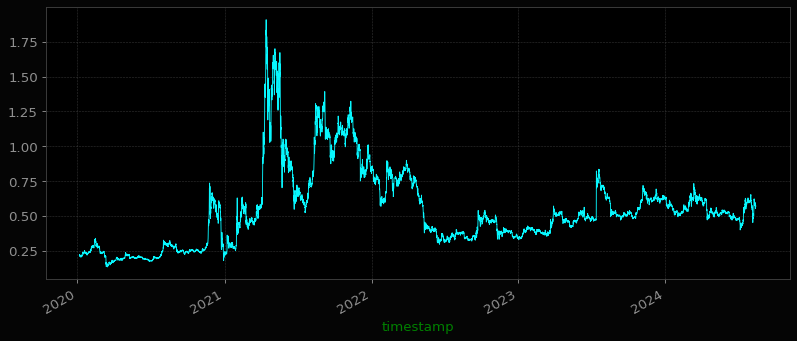

In [15]:
mcr["XRPUSDT", '2020-01-01':'2025-01-01'].close.plot()

In [ ]:
mcr.read("BTCUSDT", "2020-01-01", "2024-08-10", transform=AsPandasFrame())

In [ ]:
mcr["ATAUSDT"]

In [32]:
_P(mcr._handle_symbols_data_from_to(['LTCUSDT', 'BTCUSDT'], "2023-01-01", "2024-01-01" ));

LTCUSDT : 2191 | 2023-01-01 00:00:00 : 2024-01-01 00:00:00
BTCUSDT : 2191 | 2023-01-01 00:00:00 : 2024-01-01 00:00:00


In [33]:
_P(mcr._handle_symbols_data_from_to(['LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT'], "2021-01-01", "2024-06-01" ));

LTCUSDT : 7453 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
BTCUSDT : 7459 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
ETHUSDT : 7483 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
SOLUSDT : 7453 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00
XRPUSDT : 7453 | 2021-01-01 00:00:00 : 2024-06-01 00:00:00


In [86]:
"fff::c:/data".split("::")

['fff', 'c:/data']

In [ ]:
mcr1 = InMemoryCachedReader('BINANCE.UM', r_mqc, F)
_P(x1:=mcr1['LTCUSDT', "2021-01-01" : "2024-06-01"])
_P(x2:=mcr['LTCUSDT',  "2021-01-01" : "2024-06-01"])
all(x1==x2)

In [70]:
mcr["GALAUSDT", :'2023-01-01']

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
timestamp,,,,,,,,,
2021-09-18 00:00:00,0.11358,0.12022,0.11148,0.11445,6.305044e+07,7351074.5,22840,26654140.0,3109883.2
2021-09-18 04:00:00,0.11442,0.11887,0.10412,0.10837,2.382351e+08,26215362.0,80628,109107784.0,12020291.0
2021-09-18 08:00:00,0.10837,0.11798,0.10440,0.11310,2.995232e+08,33087352.0,95557,140715968.0,15578291.0
2021-09-18 12:00:00,0.11319,0.13840,0.11272,0.13000,1.920679e+09,250446624.0,507988,974595710.0,127152928.0
2021-09-18 16:00:00,0.13000,0.13190,0.11319,0.11586,1.028713e+09,124677496.0,271595,498680224.0,60459776.0
...,...,...,...,...,...,...,...,...,...
2022-12-31 08:00:00,0.01640,0.01655,0.01632,0.01641,2.386384e+08,3919607.0,14892,118997912.0,1955452.8
2022-12-31 12:00:00,0.01640,0.01692,0.01633,0.01661,6.860614e+08,11443808.0,35514,356820256.0,5953916.0
2022-12-31 16:00:00,0.01661,0.01678,0.01649,0.01652,3.119849e+08,5189706.0,17815,146555328.0,2438995.5


# Loader with external custom data and time cut

Load external data

In [3]:
aux_all = pd.read_csv("../tests/data/csv/electricity_data.csv.gz", parse_dates=['datetime'])
electro_aux = aux_all[(aux_all['stateDescription'] == 'U.S. Total') & (aux_all['sectorName']=='all sectors')].set_index("datetime", drop=True)

In [6]:
class _FixTimeProvider:
    def __init__(self, time: str):
        self._t_g = np.datetime64(time)
        
    def time(self) -> np.datetime64: 
        return self._t_g

ldr = loader(
    "BINANCE.UM", '1h', 
    electro=electro_aux,
    # source="csv::../tests/data/csv/", 
    source="mqdb::xlydian-data", 
    # time_provider=_FixTimeProvider("2022-06-01 05:00"),
    n_jobs=1
)

ldr2 = TimeGuardedWrapper(ldr, _FixTimeProvider("2022-06-01 05:00"))

In [7]:
ldr.read('BTCUSDT', '2010-01-01', '2025-01-01', transform=AsPandasFrame())[-10:]

,close,count,high,low,open,quote_volume,taker_buy_quote_volume,taker_buy_volume,volume
timestamp,,,,,,,,,
2024-08-12 14:00:00,60265.3,681536,60666.0,57774.0,58133.7,3.703901e+09,1.932832e+09,32528.994,62330.016
2024-08-12 15:00:00,60171.2,426855,60480.0,59185.0,60265.2,2.018770e+09,9.953612e+08,16643.346,33760.292
2024-08-12 16:00:00,59581.7,226780,60390.8,59527.0,60171.3,1.032012e+09,5.079472e+08,8480.689,17232.520
2024-08-12 17:00:00,59276.9,149532,59894.1,59230.0,59581.7,5.871030e+08,2.922585e+08,4907.444,9861.674
2024-08-12 18:00:00,58511.2,208116,59470.0,58403.9,59276.9,8.330728e+08,3.929505e+08,6665.615,14133.826
2024-08-12 19:00:00,59025.9,180149,59268.9,58511.3,58511.4,7.433530e+08,3.899504e+08,6615.156,12607.053
2024-08-12 20:00:00,58817.6,152267,59371.9,58700.4,59026.0,6.330574e+08,2.996865e+08,5071.363,10717.172
2024-08-12 21:00:00,58951.2,132621,59204.4,58520.7,58817.6,4.531524e+08,2.290527e+08,3893.321,7704.346
2024-08-12 22:00:00,59030.0,87054,59231.6,58814.0,58951.2,2.665176e+08,1.353471e+08,2291.953,4514.001


In [8]:
ldr2.read('BTCUSDT', '2010-01-01', '2025-01-01', transform=AsPandasFrame())[-10:]

,close,count,high,low,open,quote_volume,taker_buy_quote_volume,taker_buy_volume,volume
timestamp,,,,,,,,,
2022-05-31 19:00:00,31618.9,149301,31779.0,31569.0,31671.7,458827680.0,239063024.0,7544.353,14481.728
2022-05-31 20:00:00,31804.3,89930,31804.3,31586.2,31618.5,243035056.0,137887824.0,4348.907,7666.311
2022-05-31 21:00:00,31714.8,67761,31830.8,31648.0,31804.3,184855552.0,86045520.0,2709.256,5821.417
2022-05-31 22:00:00,31856.3,80533,31889.0,31673.3,31714.8,266157600.0,147680640.0,4645.114,8372.720
2022-05-31 23:00:00,31797.8,76345,31932.3,31763.2,31856.2,226696704.0,110160664.0,3457.619,7116.994
2022-06-01 00:00:00,31925.5,132462,31986.1,31680.0,31797.9,432640256.0,219572832.0,6894.888,13588.892
2022-06-01 01:00:00,31914.9,69205,31938.6,31825.7,31925.5,185599760.0,86580632.0,2715.666,5821.939
2022-06-01 02:00:00,31794.1,89465,31915.0,31710.0,31914.9,289264608.0,124065464.0,3901.611,9097.811
2022-06-01 03:00:00,31624.0,90844,31799.7,31610.1,31794.2,279394176.0,119767088.0,3780.162,8818.014


In [9]:
ldr.get_aux_data_ids()

{'average_quote_volume', 'candles', 'electro', 'fundamental_data', 'symbols'}

In [10]:
ldr['BTCUSDT', '2019-01-01':'2023-01-01']

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
timestamp,,,,,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7170.15,7171.55,2449.049,17576424.0,3688,996.198,7149371.0
2020-01-01 01:00:00,7171.43,7225.00,7171.10,7210.24,3865.038,27838048.0,6635,2340.879,16860294.0
2020-01-01 02:00:00,7210.38,7239.30,7206.46,7237.99,3228.365,23324808.0,5120,1774.145,12818472.0
2020-01-01 03:00:00,7237.41,7239.74,7215.00,7221.65,2513.307,18161820.0,4143,1245.065,8996219.0
2020-01-01 04:00:00,7221.80,7225.41,7211.22,7213.86,1176.666,8493631.0,1966,586.864,4236085.0
...,...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,16564.30,16569.70,16562.00,16563.50,2395.389,39680492.0,15152,1242.505,20582802.0
2022-12-31 21:00:00,16563.50,16566.40,16538.60,16544.00,4092.845,67750600.0,22112,1571.773,26020454.0
2022-12-31 22:00:00,16544.00,16565.10,16461.80,16515.10,16666.568,275284320.0,77358,7078.976,116949992.0


In [11]:
ldr2['BTCUSDT', '2019-01-01':'2023-01-01']

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
timestamp,,,,,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7170.15,7171.55,2449.049,17576424.0,3688,996.198,7149371.0
2020-01-01 01:00:00,7171.43,7225.00,7171.10,7210.24,3865.038,27838048.0,6635,2340.879,16860294.0
2020-01-01 02:00:00,7210.38,7239.30,7206.46,7237.99,3228.365,23324808.0,5120,1774.145,12818472.0
2020-01-01 03:00:00,7237.41,7239.74,7215.00,7221.65,2513.307,18161820.0,4143,1245.065,8996219.0
2020-01-01 04:00:00,7221.80,7225.41,7211.22,7213.86,1176.666,8493631.0,1966,586.864,4236085.0
...,...,...,...,...,...,...,...,...,...
2022-06-01 00:00:00,31797.90,31986.10,31680.00,31925.50,13588.892,432640256.0,132462,6894.888,219572832.0
2022-06-01 01:00:00,31925.50,31938.60,31825.70,31914.90,5821.939,185599760.0,69205,2715.666,86580632.0
2022-06-01 02:00:00,31914.90,31915.00,31710.00,31794.10,9097.811,289264608.0,89465,3901.611,124065464.0


In [27]:
ldr.get_aux_data('candles', symbols=['SOLUSDT', 'ETHUSDT'], start='2020-01-01', stop='2025-01-01')

open      high       low     close        volume  \
timestamp  symbol                                                          
2020-01-01 ETHUSDT   129.120   132.960   128.620   130.620  4.660639e+05   
2020-01-02 ETHUSDT   130.630   130.750   126.250   127.110  5.235829e+05   
2020-01-03 ETHUSDT   127.110   135.070   125.780   134.290  9.511236e+05   
2020-01-04 ETHUSDT   134.310   135.800   132.410   134.140  5.097781e+05   
2020-01-05 ETHUSDT   134.140   138.170   134.120   135.330  6.696777e+05   
...                      ...       ...       ...       ...           ...   
2024-08-10 ETHUSDT  2597.890  2644.430  2574.540  2608.760  1.311479e+06   
2024-08-11 ETHUSDT  2608.770  2720.780  2537.760  2554.650  2.629489e+06   
           SOLUSDT   153.933   157.950   141.038   141.492  1.758467e+07   
2024-08-12 SOLUSDT   141.493   150.727   141.128   146.241  2.737586e+07   
           ETHUSDT  2554.660  2749.970  2506.130  2721.150  4.126997e+06   

                    quote_volume    count  taker_buy_volume  \
timestamp  symbol                                             
2020-01-01 ETHUSDT  6.103756e+07    40168      2.324929e+05   
2020-01-02 ETHUSDT  6.737797e+07    47479      2.538406e+05   
2020-01-03 ETHUSDT  1.250189e+08   106861      4.861591e+05   
2020-01-04 ETHUSDT  6.815393e+07    65138      2.573048e+05   
2020-01-05 ETHUSDT  9.109860e+07    71080      3.321899e+05   
...                          ...      ...               ...   
2024-08-10 ETHUSDT  3.425329e+09  2176236      6.595712e+05   
2024-08-11 ETHUSDT  6.903526e+09  3711479      1.293433e+06   
           SOLUSDT  2.626976e+09  2064586      8.411000e+06   
2024-08-12 SOLUSDT  3.992101e+09  2944267      1.353778e+07   
           ETHUSDT  1.088096e+10  5678213      2.066389e+06   

                    taker_buy_quote_volume  
timestamp  symbol                           
2020-01-01 ETHUSDT            3.044614e+07  
2020-01-02 ETHUSDT            3.267493e+07  
2020-01-03 ETHUSDT            6.390715e+07  
2020-01-04 ETHUSDT            3.440635e+07  
2020-01-05 ETHUSDT            4.518600e+07  
...                                    ...  
2024-08-10 ETHUSDT            1.722922e+09  
2024-08-11 ETHUSDT            3.396187e+09  
           SOLUSDT            1.257421e+09  
2024-08-12 SOLUSDT            1.974189e+09  
           ETHUSDT            5.450954e+09  

[3110 rows x 9 columns]

In [28]:
ldr2.get_aux_data('candles', symbols=['SOLUSDT', 'ETHUSDT'], start='2020-01-01', stop='2025-01-01')

open     high      low    close        volume  \
timestamp  symbol                                                      
2020-01-01 ETHUSDT   129.12   132.96   128.62   130.62  4.660639e+05   
2020-01-02 ETHUSDT   130.63   130.75   126.25   127.11  5.235829e+05   
2020-01-03 ETHUSDT   127.11   135.07   125.78   134.29  9.511236e+05   
2020-01-04 ETHUSDT   134.31   135.80   132.41   134.14  5.097781e+05   
2020-01-05 ETHUSDT   134.14   138.17   134.12   135.33  6.696777e+05   
...                     ...      ...      ...      ...           ...   
2022-05-30 SOLUSDT    44.95    48.58    44.24    47.21  2.430210e+07   
2022-05-31 SOLUSDT    47.21    48.23    44.52    45.76  2.088084e+07   
           ETHUSDT  1997.87  2016.77  1922.00  1941.68  2.655077e+06   
2022-06-01 SOLUSDT    45.75    46.12    39.49    40.09  2.581970e+07   
           ETHUSDT  1941.68  1972.77  1758.52  1817.10  3.499272e+06   

                    quote_volume    count  taker_buy_volume  \
timestamp  symbol                                             
2020-01-01 ETHUSDT  6.103756e+07    40168      2.324929e+05   
2020-01-02 ETHUSDT  6.737797e+07    47479      2.538406e+05   
2020-01-03 ETHUSDT  1.250189e+08   106861      4.861591e+05   
2020-01-04 ETHUSDT  6.815393e+07    65138      2.573048e+05   
2020-01-05 ETHUSDT  9.109860e+07    71080      3.321899e+05   
...                          ...      ...               ...   
2022-05-30 SOLUSDT  1.124259e+09  1000940      1.216808e+07   
2022-05-31 SOLUSDT  9.663097e+08   894955      1.005986e+07   
           ETHUSDT  5.223237e+09  2673228      1.304184e+06   
2022-06-01 SOLUSDT  1.107354e+09  1135749      1.247697e+07   
           ETHUSDT  6.601369e+09  3352330      1.713993e+06   

                    taker_buy_quote_volume  
timestamp  symbol                           
2020-01-01 ETHUSDT            3.044614e+07  
2020-01-02 ETHUSDT            3.267493e+07  
2020-01-03 ETHUSDT            6.390715e+07  
2020-01-04 ETHUSDT            3.440635e+07  
2020-01-05 ETHUSDT            4.518600e+07  
...                                    ...  
2022-05-30 SOLUSDT            5.630771e+08  
2022-05-31 SOLUSDT            4.655865e+08  
           ETHUSDT            2.566088e+09  
2022-06-01 SOLUSDT            5.349406e+08  
           ETHUSDT            3.234941e+09  

[1504 rows x 9 columns]

In [29]:
ldr.get_aux_data("fundamental_data", start="2020-01-01", stop="2025-01-01")

metric                 market_cap       price        volume    volume_usd
timestamp  symbol                                                        
2020-01-01 BTCUSDT   1.303941e+11  7189.00000  8.920344e+04  6.412835e+08
2020-01-02 BTCUSDT   1.304230e+11  7197.57000  5.680133e+04  4.088315e+08
2020-01-03 BTCUSDT   1.262808e+11  6962.04000  1.152957e+05  8.026931e+08
2020-01-04 BTCUSDT   1.327663e+11  7341.72000  2.084935e+05  1.530701e+09
2020-01-05 BTCUSDT   1.334747e+11  7350.71000  9.258603e+04  6.805731e+08
...                           ...         ...           ...           ...
2024-09-20 ZETAUSDT  2.689762e+08     0.68290  2.700577e+08  1.844224e+08
           ZILUSDT   2.707985e+08     0.01425  4.107936e+08  5.853808e+06
           ZKUSDT    4.513086e+08     0.12260  2.795359e+08  3.427111e+07
           ZROUSDT   4.702246e+08     4.26900  3.182333e+07  1.358538e+08
           ZRXUSDT   2.689234e+08     0.31470  2.742725e+07  8.631357e+06

[221741 rows x 4 columns]

In [31]:
ldr2.get_aux_data("fundamental_data", start="2020-01-01", stop="2025-01-01")

metric                market_cap       price        volume    volume_usd
timestamp  symbol                                                       
2020-01-01 BTCUSDT  1.303941e+11  7189.00000  8.920344e+04  6.412835e+08
2020-01-02 BTCUSDT  1.304230e+11  7197.57000  5.680133e+04  4.088315e+08
2020-01-03 BTCUSDT  1.262808e+11  6962.04000  1.152957e+05  8.026931e+08
2020-01-04 BTCUSDT  1.327663e+11  7341.72000  2.084935e+05  1.530701e+09
2020-01-05 BTCUSDT  1.334747e+11  7350.71000  9.258603e+04  6.805731e+08
...                          ...         ...           ...           ...
2022-06-01 YFIUSDT  2.561335e+08  8053.00000  6.138342e+03  4.943207e+07
           ZECUSDT  1.174585e+09    93.19000  8.564168e+05  7.980949e+07
           ZENUSDT  2.795736e+08    22.29700  7.005560e+05  1.562030e+07
           ZILUSDT  7.947090e+08     0.05482  6.070175e+09  3.327670e+08
           ZRXUSDT  3.572817e+08     0.42050  6.761951e+07  2.843401e+07

[74372 rows x 4 columns]

# Test in strategy

In [5]:
class Tester(IStrategy):
    exchange: str = "BINANCE.UM"
    min_capitalization_mil: float = 400
    # hist_reader: MultiQdbConnector | None = None

    def on_start(self, ctx: StrategyContext):
        f_data = ctx.get_aux_data("fundamental_data", symbols=None, timeframe='1d', start="2020-01-01")
        print(f_data)

    def on_fit(
        self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None
    ):
        stop = pd.Timestamp(fit_time)
        start = stop - pd.Timedelta('5d')  # type: ignore
        logger.info(f"Fitting on data range: {start} : {stop}")
        # fundamental = self.hist_reader.get_fundamental_data(self.exchange, start, stop)

        # _last_caps = pd.Series(fundamental["market_cap"].groupby("symbol").last().to_dict())
        # _last_caps = _last_caps[_last_caps >= self.min_capitalization_mil * 1e6]
        # symbols_available = set(_last_caps.index)
        # raw_data = self.hist_reader.get_candles(
        #     self.exchange, list(symbols_available), start, stop, '1d'
        # )
        # logger.info(str(raw_data.head()))

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        logger.info(f"Event: {ctx.time()}")
        return None


In [3]:
rd = loader("BINANCE.UM", '1h', source="mqdb::xlydian-data", n_jobs=1)
rd2 = TimeGuardedWrapper(rd, _FixTimeProvider("2023-06-01 05:00"))

2024-10-18 18:07:46.931 [ 🐞 ] Connected to QuestDB at xlydian-data:8812
2024-10-18 18:10:37.993 [ 🐞 ] Tester new parameters:
	set min_capitalization_mil <- 400


NameError: name '_FixTimeProvider' is not defined

In [ ]:
rd['BTCUSDT', '2020-01-01':'2021-01-01']

In [7]:
r = simulate({ 'mtx0': Tester(min_capitalization_mil=400) },
    rd,
    capital=100000, instruments=["BINANCE.UM:BTCUSDT"], commissions="vip0_usdt",
    trigger="1d -5Min", 
    subscription=dict(type="ohlc", timeframe='1h', nback=14*24),
    fit='50 23 * */2 L7', # last Sun each 3'rd month
    start="2023-01-01 00:00", stop="2024-01-10",
    debug="DEBUG", 
    aux_data=rd,
)

2024-10-18 18:11:31.978 [ 🐞 ] 2023-01-01 00:00:00 Initiating simulated trading for binance.um for 100000 x 1.0 in USDT...
2023-01-01 00:00:00.000 [ℹ️] SimulatedData.binance.um initialized
2023-01-01 00:00:00.000 [🐞] Triggering strategy on every 1d bar after 23h55Min
2023-01-01 00:00:00.000 [🐞] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1h', 'nback': 336} for 
	['BTCUSDT'] 
metric                market_cap       price        volume    volume_usd
timestamp  symbol                                                       
2020-01-01 BTCUSDT  1.303941e+11  7189.00000  8.920344e+04  6.412835e+08
2020-01-02 BTCUSDT  1.304230e+11  7197.57000  5.680133e+04  4.088315e+08
2020-01-03 BTCUSDT  1.262808e+11  6962.04000  1.152957e+05  8.026931e+08
2020-01-04 BTCUSDT  1.327663e+11  7341.72000  2.084935e+05  1.530701e+09
2020-01-05 BTCUSDT  1.334747e+11  7350.71000  9.258603e+04  6.805731e+08
...                          ...         ...           ...           ...
2023-01-01 YFIUS

Simulating:   0%|          | 0/32313600.0 [00:00<?, ?s/s]

2023-01-01 00:00:00.000 [ℹ️] SimulatedExchangeService :: run :: Simulation started at 2023-01-01 00:00
2023-01-01 00:00:00.000 [🐞] Initializing chunks for each loader
2023-01-01 00:00:00.000 [🐞] Invoking Tester on_fit('2022-11-27 23:50:00', 'None')
2023-01-01 00:00:00.000 [ℹ️] Fitting on data range: 2022-11-22 23:50:00 : 2022-11-27 23:50:00
2023-01-01 00:00:00.000 [🐞] Tester is fitted
2023-01-01 23:59:59.999 [ℹ️] Event: 2023-01-01T23:59:59.999000000
2023-01-02 23:59:59.999 [ℹ️] Event: 2023-01-02T23:59:59.999000000
2023-01-03 23:59:59.999 [ℹ️] Event: 2023-01-03T23:59:59.999000000
2023-01-04 23:59:59.999 [ℹ️] Event: 2023-01-04T23:59:59.999000000
2023-01-05 23:59:59.999 [ℹ️] Event: 2023-01-05T23:59:59.999000000
2023-01-06 23:59:59.999 [ℹ️] Event: 2023-01-06T23:59:59.999000000
2023-01-07 23:59:59.999 [ℹ️] Event: 2023-01-07T23:59:59.999000000
2023-01-08 23:59:59.999 [ℹ️] Event: 2023-01-08T23:59:59.999000000
2023-01-09 23:59:59.999 [ℹ️] Event: 2023-01-09T23:59:59.999000000
2023-01-10 23:59:5